In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
# import lightgbm as lgb
# import xgboost as xgb
%matplotlib inline
import os
import datetime
from tqdm.notebook import tqdm

In [2]:
DATA_FOLDER = '../Data/'

transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test            = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))
samplesub       = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv.gz'))

In [3]:
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
(items.index==items.item_id).all()

True

In [6]:
def information(rtd):
    info = pd.DataFrame({'Column': rtd.columns})
    info['unique'] = [len(rtd[c].unique()) for c in rtd.columns]
    info['type'] = [rtd[c].dtype for c in rtd.columns]
    info['isNull'] = [sum(rtd[c].isnull()) for c in rtd.columns]
    info['mode example'] = [rtd[c].mode()[0] for c in rtd.columns]
    return info.set_index('Column')

In [64]:
transactions['date'] = pd.to_datetime(transactions.date, format='%d.%m.%Y')

transactions['day']     = transactions.date.dt.day
transactions['month']   = transactions.date.dt.month
transactions['year']    = transactions.date.dt.year
transactions['weekday'] = transactions.date.dt.weekday
transactions['yrday']   = (transactions.date - pd.to_datetime(transactions.year, format='%Y')).dt.days

In [65]:
transactions['item_category_id'] = transactions.item_id.map(items.item_category_id)
transactions.item_cnt_day = transactions.item_cnt_day.clip(0, 20)

In [9]:
information(transactions)

,unique,type,isNull,mode example
Column,,,,
date,1034,datetime64[ns],0,2013-12-28 00:00:00
date_block_num,34,int64,0,11
shop_id,60,int64,0,31
item_id,21807,int64,0,20949
item_price,19993,float64,0,299
item_cnt_day,198,float64,0,1
day,31,int32,0,2
month,12,int32,0,1
year,3,int32,0,2013


In [10]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [11]:
samplesub.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [12]:
test.shape

(214200, 3)

In [13]:
samplesub.shape

(214200, 2)

In [14]:
information(test)

,unique,type,isNull,mode example
Column,,,,
ID,214200,int64,0,0
shop_id,42,int64,0,2
item_id,5100,int64,0,30


In [15]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [16]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [17]:
from pandas_profiling import ProfileReport
prof = ProfileReport(transactions)
prof.to_file(output_file='profile.html')

### to do

1. check the item price  it has bad min and max data
2. check the item count as well 
3. 

<AxesSubplot:xlabel='date'>

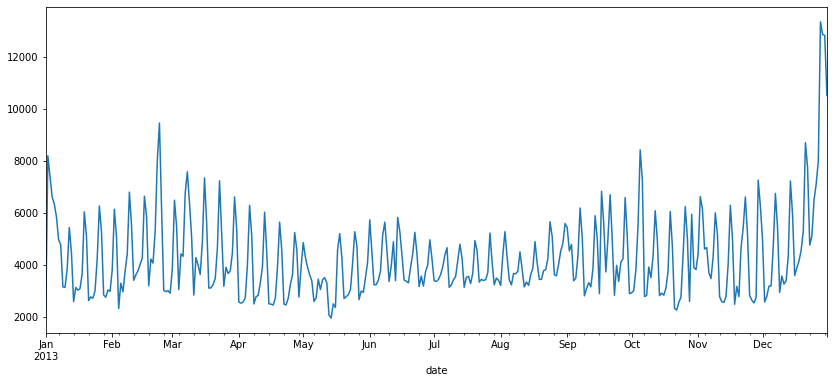

In [18]:
plt.figure(figsize=(14, 6))
transactions[transactions.year==2013].groupby('date').item_cnt_day.sum().plot()

<AxesSubplot:xlabel='weekday'>

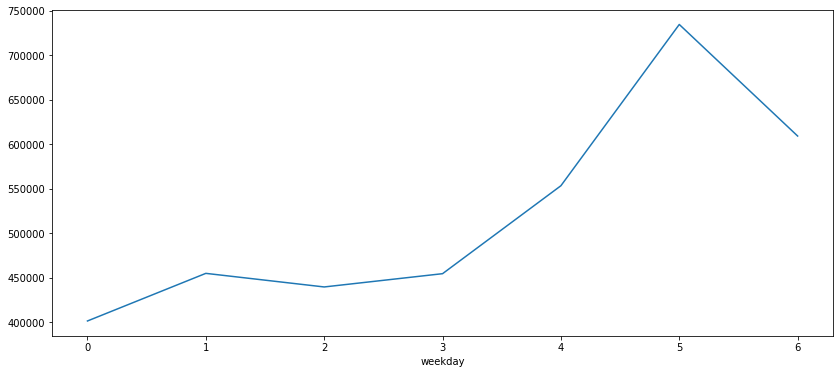

In [19]:
plt.figure(figsize=(14, 6))
transactions.groupby('weekday').item_cnt_day.sum().plot()

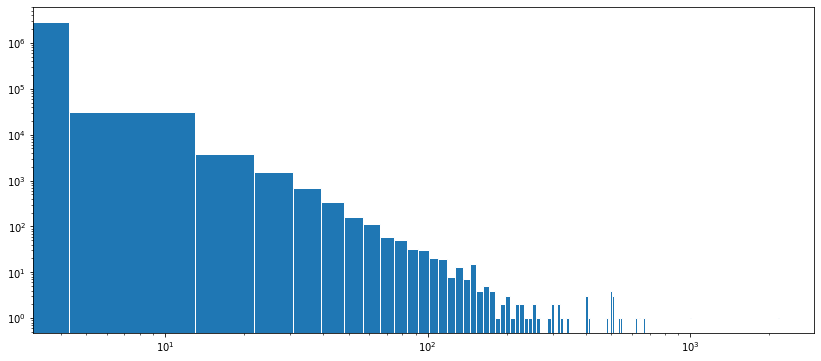

In [20]:
plt.figure(figsize=(14, 6))
plt.xscale('log')
plt.yscale('log')
plt.hist(transactions.item_cnt_day, bins = 250, edgecolor='white')
plt.show()

clip the values above 100 or 20 or 10

date


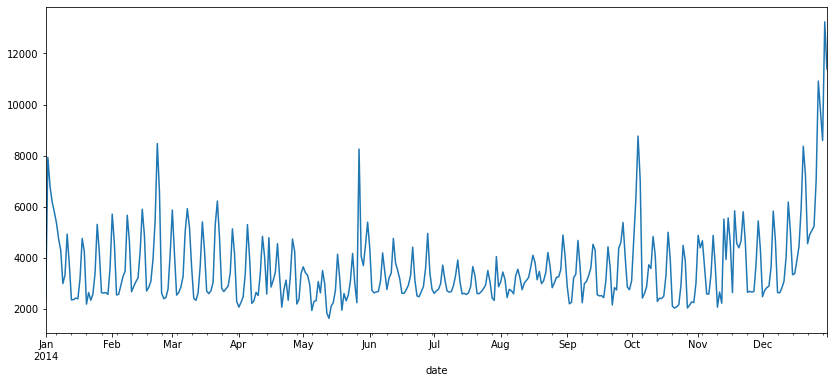

date_block_num


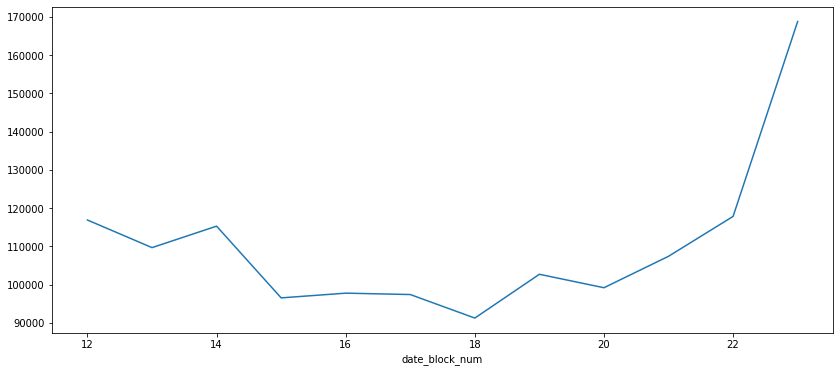

shop_id


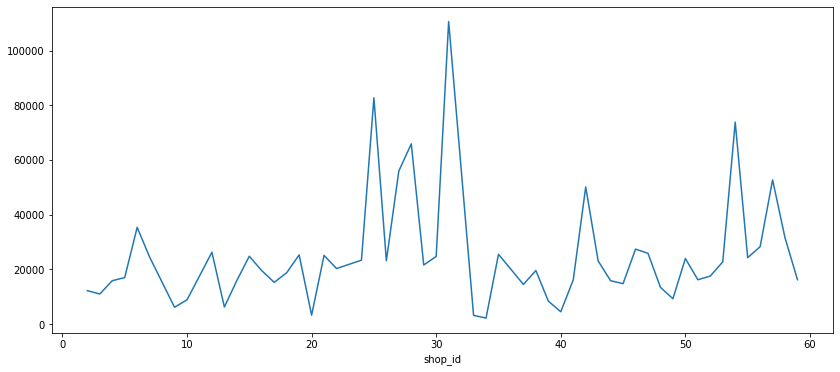

item_id


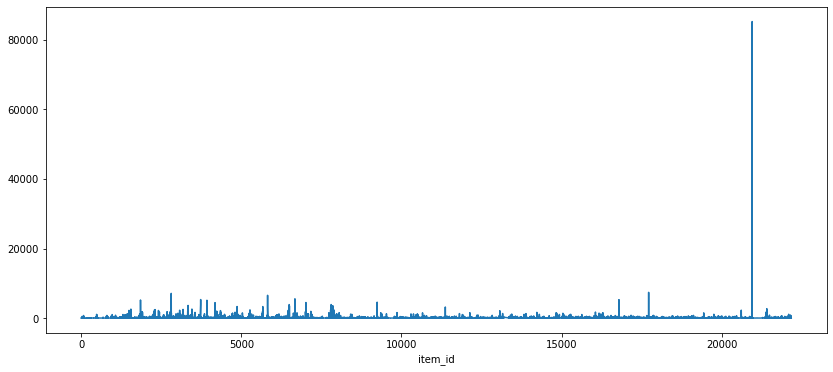

item_price


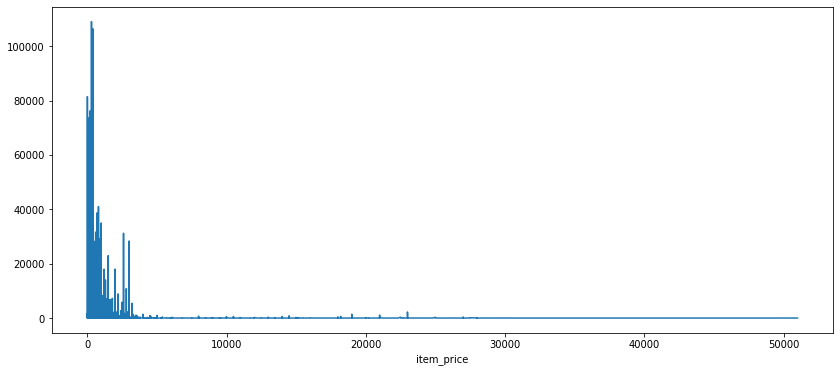

item_cnt_day


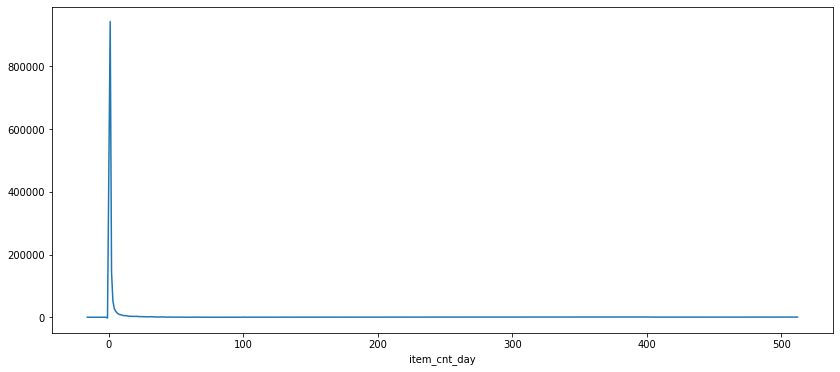

day


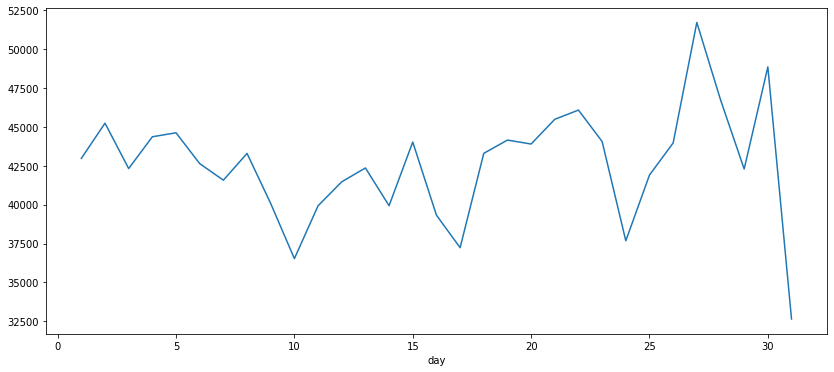

month


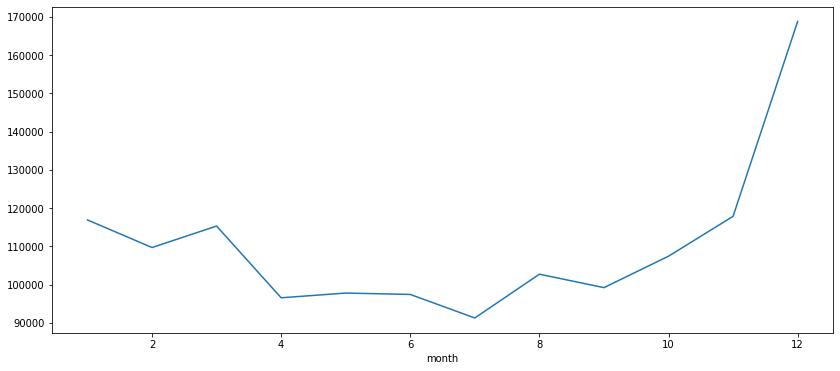

year


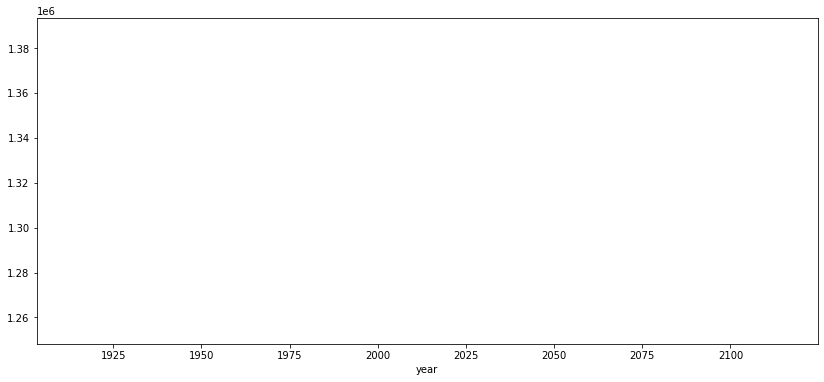

weekday


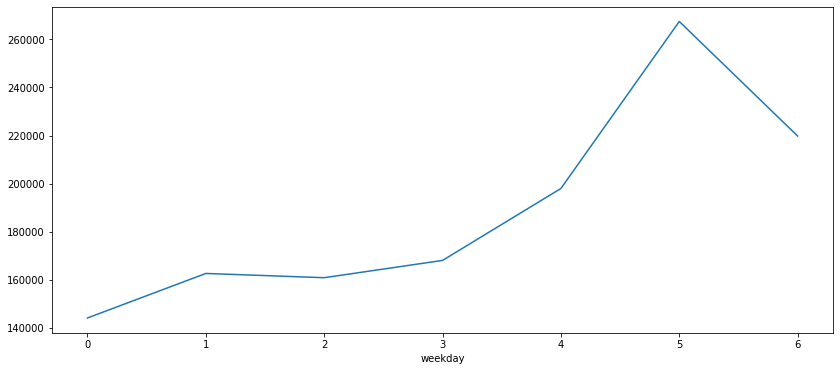

yrday


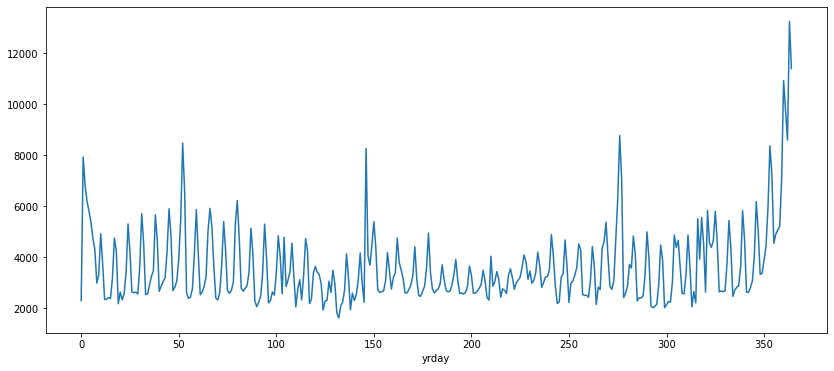

item_category_id


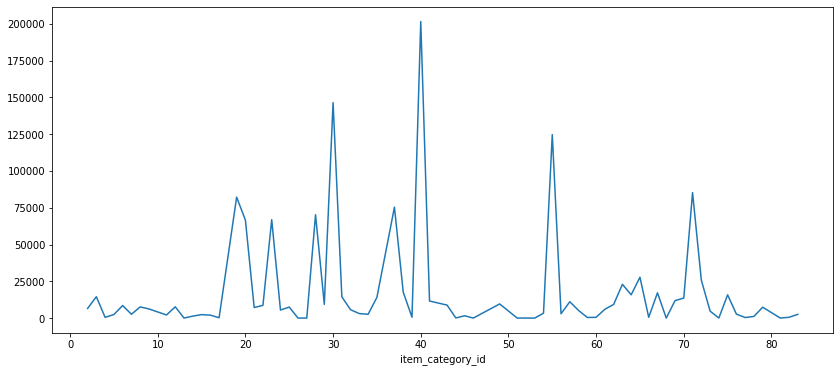

In [21]:
for col in transactions.columns:
    print (col)
    plt.figure(figsize=(14, 6))
    transactions[transactions.year==2014].groupby(col).item_cnt_day.sum().plot()
    plt.show()

In [22]:
transactions['yrday'] = (transactions.date - pd.to_datetime(transactions.year, format='%Y')).dt.days

In [27]:
def predgrouper(df, name):
    df
    gb = df.groupby(['shop_id', 'item_id']).item_cnt_day.sum()
    pred = test.copy()
    pred['item_cnt_month'] = np.zeros(pred.shape[0])
    for r in tqdm(range(pred.shape[0])):
        try:
            pred.item_cnt_month.iloc[r]=(gb.loc[pred.shop_id.iloc[r],pred.item_id.iloc[r]]).clip(0, 20)    
        except KeyError:
            continue
    timenow = datetime.datetime.now().strftime('%d-%m-%Y_%H-%M-%S_')
    pred[['ID', 'item_cnt_month']].to_csv('../preds/'+timenow+name+'.csv', index=False)

In [28]:
nov2013 = transactions[transactions.date_block_num==10]
predgrouper(nov2013, 'nov2013')

c:\users\lazyboy\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [29]:
nov2014 = transactions[transactions.date_block_num==22]
predgrouper(nov2014, 'nov2014')

c:\users\lazyboy\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
transactions.item_cnt_day = transactions.item_cnt_day.clip(0, 20)

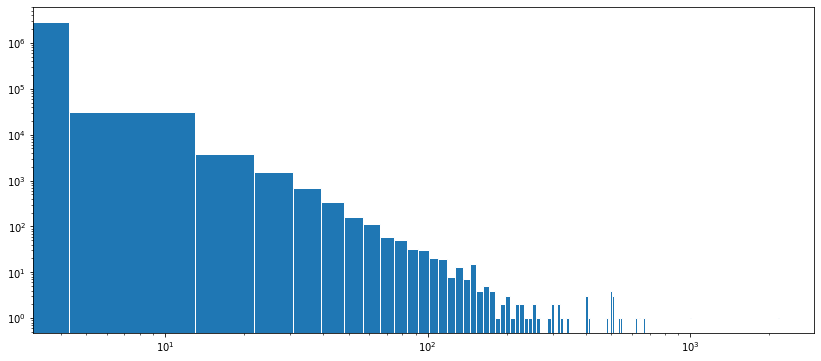

In [113]:
plt.figure(figsize=(14, 6))
plt.xscale('log')
plt.yscale('log')
plt.hist(transactions.item_cnt_day, bins = 250, edgecolor='white')
plt.show()

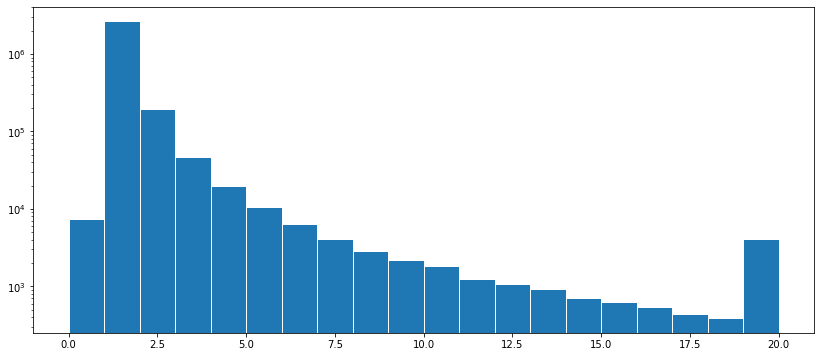

In [112]:
plt.figure(figsize=(14, 6))
plt.yscale('log')
plt.hist(transactions.item_cnt_day.clip(0, 20), bins= 20, edgecolor='white')
plt.show()

In [45]:
transactions.item_cnt_day = transactions.item_cnt_day.clip(0, 20)

In [48]:
transactions.dtypes

date                datetime64[ns]
date_block_num               int64
shop_id                      int64
item_id                      int64
item_price                 float64
item_cnt_day               float64
day                          int32
month                        int32
year                         int32
weekday                      int64
yrday                        int64
item_category_id             int64
dtype: object

In [53]:
catcols = ['shop_id', 'day', 'month', 'year', 'weekday', 'item_category_id']
for col in catcols:
    transactions[col] = transactions[col].astype('category')

In [54]:
information(transactions)

,unique,type,isNull,mode example
Column,,,,
date,1034,datetime64[ns],0,2013-12-28 00:00:00
date_block_num,34,int64,0,11
shop_id,60,category,0,31
item_id,21807,int64,0,20949
item_price,19993,float64,0,299
item_cnt_day,21,float64,0,1
day,31,category,0,2
month,12,category,0,1
year,3,category,0,2013


In [66]:
transactions.shape

(2935849, 12)

In [81]:
(transactions.item_cnt_day>40).sum()

866

In [76]:
(transactions.item_price>30000).sum()

240

In [84]:
transactions.to_hdf('../Dump/day1trans.h5', 'transactions', 'w')

In [86]:
information(shops)

,unique,type,isNull,mode example
Column,,,,
shop_name,60,object,0,"!Якутск Орджоникидзе, 56 фран"
shop_id,60,int64,0,0


In [87]:
information(item_categories)

,unique,type,isNull,mode example
Column,,,,
item_category_name,84,object,0,PC - Гарнитуры/Наушники
item_category_id,84,int64,0,0


In [88]:
information(items)

,unique,type,isNull,mode example
Column,,,,
item_name,22170,object,0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D
item_id,22170,int64,0,0
item_category_id,84,int64,0,40


In [89]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [90]:
information(test)

,unique,type,isNull,mode example
Column,,,,
ID,214200,int64,0,0
shop_id,42,int64,0,2
item_id,5100,int64,0,30


In [91]:
transactions.shape

(2935849, 12)

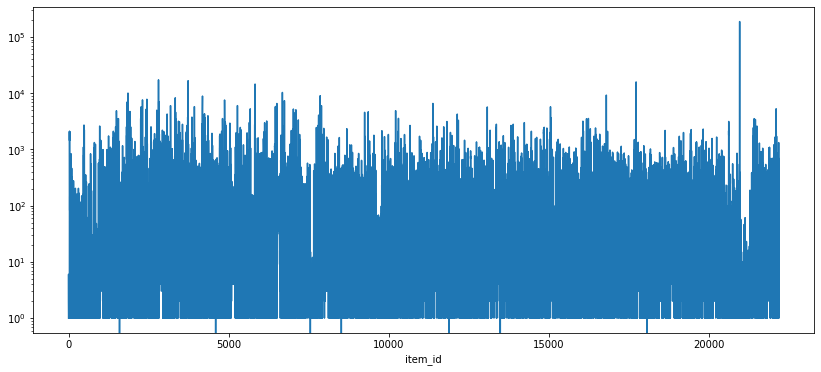

In [92]:
plt.figure(figsize=(14, 6))
plt.yscale('log')
transactions.groupby('item_id').item_cnt_day.sum().plot()
plt.show()

In [93]:
idvcnt = transactions.groupby('item_id').item_cnt_day.sum()

<AxesSubplot:>

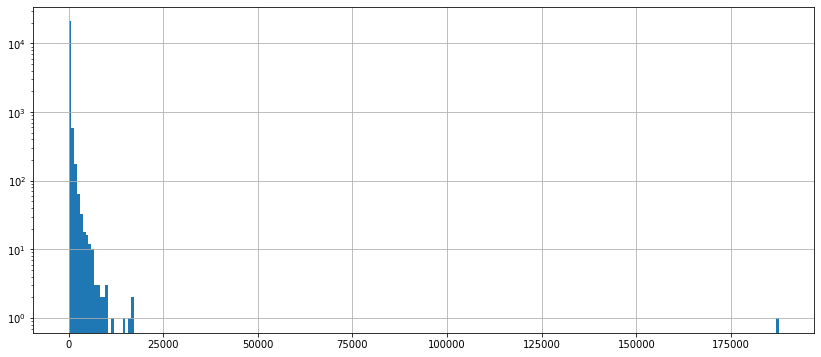

In [97]:
plt.figure(figsize=(14, 6))
plt.yscale('log')
idvcnt.hist(bins = 250)

In [98]:
idvcnt.shape

(21807,)

In [110]:
(idvcnt<10).sum()

6405

In [105]:
idvcnt.head()

item_id
0    1.0
1    6.0
2    2.0
3    2.0
4    1.0
Name: item_cnt_day, dtype: float64

In [106]:
idvcnt[idvcnt>25000]

item_id
20949    187642.0
Name: item_cnt_day, dtype: float64

In [111]:
items.iloc[20949]

item_name           Фирменный пакет майка 1С Интерес белый (34*42)...
item_id                                                         20949
item_category_id                                                   71
Name: 20949, dtype: object

In [118]:
transactions[transactions.item_id==20949]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,weekday,yrday,item_category_id
352379,2013-04-30,3,22,20949,5.000000,12.0,30,4,2013,1,119,71
352399,2013-04-29,3,22,20949,4.923077,13.0,29,4,2013,0,118,71
352400,2013-04-28,3,22,20949,5.000000,4.0,28,4,2013,6,117,71
352401,2013-04-27,3,22,20949,5.000000,4.0,27,4,2013,5,116,71
352455,2013-04-24,3,22,20949,5.000000,2.0,24,4,2013,2,113,71
...,...,...,...,...,...,...,...,...,...,...,...,...
2930644,2015-10-02,33,22,20949,5.000000,1.0,2,10,2015,4,274,71
2930645,2015-10-03,33,22,20949,5.000000,2.0,3,10,2015,5,275,71
2930646,2015-10-04,33,22,20949,5.000000,3.0,4,10,2015,6,276,71
2930647,2015-10-05,33,22,20949,5.000000,2.0,5,10,2015,0,277,71


In [115]:
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,weekday,yrday,item_category_id
0,2013-01-02,0,59,22154,999.00,1.0,2,1,2013,2,1,37
1,2013-01-03,0,25,2552,899.00,1.0,3,1,2013,3,2,58
2,2013-01-05,0,25,2552,899.00,-1.0,5,1,2013,5,4,58
3,2013-01-06,0,25,2554,1709.05,1.0,6,1,2013,6,5,58
4,2013-01-15,0,25,2555,1099.00,1.0,15,1,2013,1,14,56


In [121]:
index_cols = ['date_block_num', 'shop_id', 'item_id']
group = transactions.groupby(index_cols).item_cnt_day.sum()

In [122]:
group

date_block_num  shop_id  item_id
0               0        32         6.0
                         33         3.0
                         35         1.0
                         43         1.0
                         51         2.0
                                   ... 
33              59       22087      6.0
                         22088      2.0
                         22091      1.0
                         22100      1.0
                         22102      1.0
Name: item_cnt_day, Length: 1609124, dtype: float64